
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Before running this notebook, you must have already the numerically simulated waves associated to the representative cases of synthetic simulated TCs (obtained with MaxDiss algorithm in notebook 06)

inputs required: 
  * Synthetic simulation of historical TCs parameters (copulas obtained in *notebook 06*)
  * MaxDiss selection of synthetic simulated TCs (parameters obtained in *notebook 06*)
  * simulated waves for the above selected TCs (**outside TeslaKit**)
  
in this notebook:
  * RBF's interpolation of wave conditions based on TCs parameters (from swan simulated TCs waves)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import matplotlib.pyplot as plt

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'

db = Database(p_data)

# set site
db.SetSite('GUAM')
           

In [3]:
# --------------------------------------
# load data and set parameters

# r2 TCs Copula Simulated (dataset) 
TCs_r2_sim_params = db.Load_TCs_r2_sim_params()

# r2 TCs MDA selection and solved simulations (not solved inside teslakit)
TCs_r2_MDA_params = db.Load_TCs_r2_mda_params()
TCs_sims = db.Load_TCs_r2_mda_Simulations_hytc()



## Simulated TCs -  Radial Basis Function

In [6]:
# --------------------------------------
# prepare dataset and subset

#  RBFs training subset (TCs numerically solved)
subset = np.column_stack(
    (TCs_r2_MDA_params['pressure_min'], TCs_r2_MDA_params['velocity_mean'], 
     TCs_r2_MDA_params['gamma'], TCs_r2_MDA_params['delta'])
)

#  RBFs dataset to interpolate 
dataset = np.column_stack(
    (TCs_r2_sim_params['pressure_min'], TCs_r2_sim_params['velocity_mean'], 
     TCs_r2_sim_params['gamma'], TCs_r2_sim_params['delta'])
)


In [7]:
TCs_sims

<xarray.Dataset>
Dimensions:     (storm: 500)
Coordinates:
    time        (storm) datetime64[ns] 2020-01-03T03:00:00 ... 2020-01-02T05:...
    case        (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * storm       (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    hs          (storm) float64 0.0001502 4.785 0.01277 ... 0.5022 4.091 6.925
    dir         (storm) float64 72.98 176.5 175.8 264.3 ... 141.9 8.637 5.776
    PkDir       (storm) float64 62.5 192.5 162.5 277.5 ... 52.5 142.5 37.5 37.5
    Tm02        (storm) float64 1.761 6.998 1.568 2.746 ... 2.615 6.589 8.326
    tp          (storm) float64 2.014 12.96 1.972 5.881 ... 5.946 11.77 13.85
    Dspr        (storm) float64 35.64 32.67 27.2 30.16 ... 25.96 42.82 45.21
    WaterLevel  (storm) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Windv_x     (storm) float64 -0.02 -11.59 0.15 5.391 ... -2.766 14.82 22.17
    Windv_y     (storm) float64 -0.09 12.14 -0.1 2.909 ... 2.435 -3.777 -1.574
    x_point     (storm) float64 144.3 144.3 144.3 144.3 ... 144.3 144.3 144.3
    y_point     (storm) float64 13.46 13.46 13.46 13.46 ... 13.46 13.46 13.46
    wind_speed  (storm) float64 0.0922 16.78 0.1803 6.126 ... 3.685 15.29 22.23
    wind_dir    (storm) float64 12.53 136.3 303.7 241.6 ... 131.4 284.3 274.1
    ss          (storm) float64 -0.03685 1.349 0.1104 ... 0.03911 0.6309 0.9155
    twl         (storm) float64 -0.03554 2.852 0.1222 ... 0.2624 1.893 2.847
    mu          (storm) float64 0.9916 0.9035 0.9737 ... 0.8162 0.9369 0.7383
Attributes:
    mesh_ID:  nest0
    source:   teslakit_v0.9.1

In [7]:
# Build RBF target numpy array
# target = np.column_stack(
#     (TCs_sims.hs, TCs_sims.tp, TCs_sims.ss, TCs_sims.twl, TCs_sims.dir, TCs_sims.mu)
# )

In [8]:
# --------------------------------------
# Extract waves data from TCs simulations (this is the RBFs training target)

print(TCs_sims)
print()

# Normalize data
d_maxis = {}
d_minis = {}
tcp = TCs_sims.copy()
for k in ['hs', 'tp', 'ss', 'twl', 'mu', 'wind_speed']:
    v = tcp[k].values[:]
    mx = np.max(v)
    mn = np.min(v)
    tcp[k] =(('storm',), (v-mn)/(mx-mn))
    
    # store maxs and mins for denormalization
    d_maxis[k] = mx
    d_minis[k] = mn

tcp['dir'] = tcp['dir'] #* np.pi/180
tcp['wind_dir'] = tcp['wind_dir'] #* np.pi/180
    
print(tcp)
print()


# Build RBF target numpy array
target = np.column_stack(
    (tcp['hs'], tcp['tp'], tcp['ss'], tcp['twl'], tcp['dir'], tcp['mu'], tcp['wind_speed'], tcp['wind_dir'])
)


<xarray.Dataset>
Dimensions:     (storm: 500)
Coordinates:
    time        (storm) datetime64[ns] 2020-01-03T03:00:00 ... 2020-01-02T05:...
    case        (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * storm       (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    hs          (storm) float64 0.0001502 4.785 0.01277 ... 0.5022 4.091 6.925
    dir         (storm) float64 72.98 176.5 175.8 264.3 ... 141.9 8.637 5.776
    PkDir       (storm) float64 62.5 192.5 162.5 277.5 ... 52.5 142.5 37.5 37.5
    Tm02        (storm) float64 1.761 6.998 1.568 2.746 ... 2.615 6.589 8.326
    tp          (storm) float64 2.014 12.96 1.972 5.881 ... 5.946 11.77 13.85
    Dspr        (storm) float64 35.64 32.67 27.2 30.16 ... 25.96 42.82 45.21
    WaterLevel  (storm) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Windv_x     (storm) float64 -0.02 -11.59 0.15 5.391 ... -2.766 14.82 22.17
    Windv_y     (storm) float64 -0.09 12.14 -0.1 2.909 ... 

(array([102.,  46.,  62.,  96.,  68.,  48.,  23.,  11.,   7.,  37.]),
 array([2.8690000e-01, 3.6218210e+01, 7.2149520e+01, 1.0808083e+02,
        1.4401214e+02, 1.7994345e+02, 2.1587476e+02, 2.5180607e+02,
        2.8773738e+02, 3.2366869e+02, 3.5960000e+02]),
 <BarContainer object of 10 artists>)

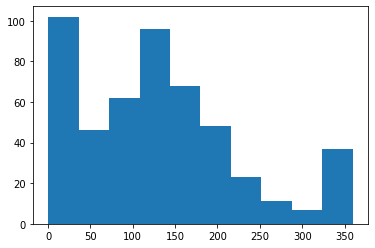

In [9]:
plt.hist(target[:,4])

In [10]:
# --------------------------------------
# RBF Interpolation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5,6]  # scalar (Hs, Tp, SS, TWL, MU, Wind_speed)
ix_directional_target = [4,7]     # directional (Dir, Wind_dir)

output = RBF_Reconstruction(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target,
    dataset)


ix_scalar: 0,  optimization: 7.55 | interpolation: 2.12
ix_scalar: 1,  optimization: 7.81 | interpolation: 2.11
ix_scalar: 2,  optimization: 15.05 | interpolation: 2.16
ix_scalar: 3,  optimization: 7.82 | interpolation: 2.10
ix_scalar: 5,  optimization: 8.02 | interpolation: 2.14
ix_scalar: 6,  optimization: 7.66 | interpolation: 2.11
ix_directional: 4,  optimization: 15.50 | interpolation: 4.20
ix_directional: 7,  optimization: 17.30 | interpolation: 4.17


(array([11480.,  8507.,  8572., 12237.,  4742.,  1678.,   455.,   316.,
          344.,  1836.]),
 array([3.20520001e-03, 3.60027253e+01, 7.20022454e+01, 1.08001766e+02,
        1.44001286e+02, 1.80000806e+02, 2.16000326e+02, 2.51999846e+02,
        2.87999366e+02, 3.23998886e+02, 3.59998406e+02]),
 <BarContainer object of 10 artists>)

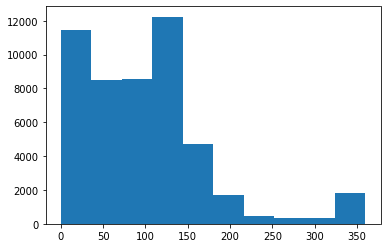

In [11]:
plt.hist(output[:,4])

In [14]:
d_maxis

{'hs': 15.32,
 'tp': 16.73,
 'ss': 1.491775399999999,
 'twl': 4.256036540364084,
 'mu': 1.1915244066364519,
 'wind_speed': 52.472622385392555}

In [15]:
# --------------------------------------
# Reconstructed TCs

# denormalize RBF output
TCs_RBF_out = xr.Dataset(
    {
        'hs':(('storm',), output[:,0] * (d_maxis['hs']-d_minis['hs']) + d_minis['hs'] ),
        'tp':(('storm',), output[:,1] * (d_maxis['tp']-d_minis['tp']) + d_minis['tp'] ),
        'ss':(('storm',), output[:,2] * (d_maxis['ss']-d_minis['ss']) + d_minis['ss'] ),
        'twl':(('storm',), output[:,3] * (d_maxis['twl']-d_minis['twl']) + d_minis['twl'] ),
        'dir':(('storm',), output[:,4]),
        'mu':(('storm',), output[:,5]* (d_maxis['mu']-d_minis['mu']) + d_minis['mu']) ,
        'wind_speed':(('storm',), output[:,6]* (d_maxis['wind_speed']-d_minis['wind_speed']) + d_minis['wind_speed']) ,
        'wind_dir':(('storm',), output[:,7]) 
    },
    coords = {'storm': np.arange(output.shape[0])}
)
print(TCs_RBF_out)

# store data as xarray.Dataset
db.Save_TCs_sim_r2_rbf_output(TCs_RBF_out)


<xarray.Dataset>
Dimensions:     (storm: 50167)
Coordinates:
  * storm       (storm) int64 0 1 2 3 4 5 ... 50162 50163 50164 50165 50166
Data variables:
    hs          (storm) float64 2.152 4.281 7.521 2.757 ... 1.511 1.544 7.451
    tp          (storm) float64 9.613 10.17 10.87 11.37 ... 6.391 6.959 12.06
    ss          (storm) float64 0.3167 0.4363 0.6592 ... 0.1191 0.1391 1.099
    twl         (storm) float64 1.068 1.478 2.235 1.368 ... 0.5064 0.6401 2.833
    dir         (storm) float64 134.4 100.9 50.16 107.4 ... 171.6 157.7 1.192
    mu          (storm) float64 0.8532 0.7151 0.8793 ... 0.7801 0.7196 0.8545
    wind_speed  (storm) float64 9.113 23.29 32.21 15.17 ... 12.36 8.985 28.26
    wind_dir    (storm) float64 17.44 151.1 49.93 93.69 ... 216.5 133.1 304.8


In [18]:
# plt.hist(TCs_RBF_out.dir)

In [17]:
# --------------------------------------
# RBF Validation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5,6]  # scalar (Hs, Tp, SS, TWL, MU, wind_speed)
ix_directional_target = [4,7]     # directional (Dir, wind_dir)

output = RBF_Validation(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target)


RBFs Kfold Validation: 1/3
ix_scalar: 0,  optimization: 3.12 | interpolation: 0.01
ix_scalar: 1,  optimization: 4.36 | interpolation: 0.01
ix_scalar: 2,  optimization: 7.33 | interpolation: 0.01
ix_scalar: 3,  optimization: 3.06 | interpolation: 0.01
ix_scalar: 5,  optimization: 3.82 | interpolation: 0.01
ix_scalar: 6,  optimization: 3.00 | interpolation: 0.01
ix_directional: 4,  optimization: 6.87 | interpolation: 0.02
ix_directional: 7,  optimization: 6.77 | interpolation: 0.02
mean squared error : 1613.865042906588

RBFs Kfold Validation: 2/3
ix_scalar: 0,  optimization: 3.82 | interpolation: 0.01
ix_scalar: 1,  optimization: 3.84 | interpolation: 0.01
ix_scalar: 2,  optimization: 7.54 | interpolation: 0.01
ix_scalar: 3,  optimization: 3.05 | interpolation: 0.01
ix_scalar: 5,  optimization: 3.95 | interpolation: 0.01
ix_scalar: 6,  optimization: 4.14 | interpolation: 0.01
ix_directional: 4,  optimization: 7.92 | interpolation: 0.02
ix_directional: 7,  optimization: 7.96 | interpolat

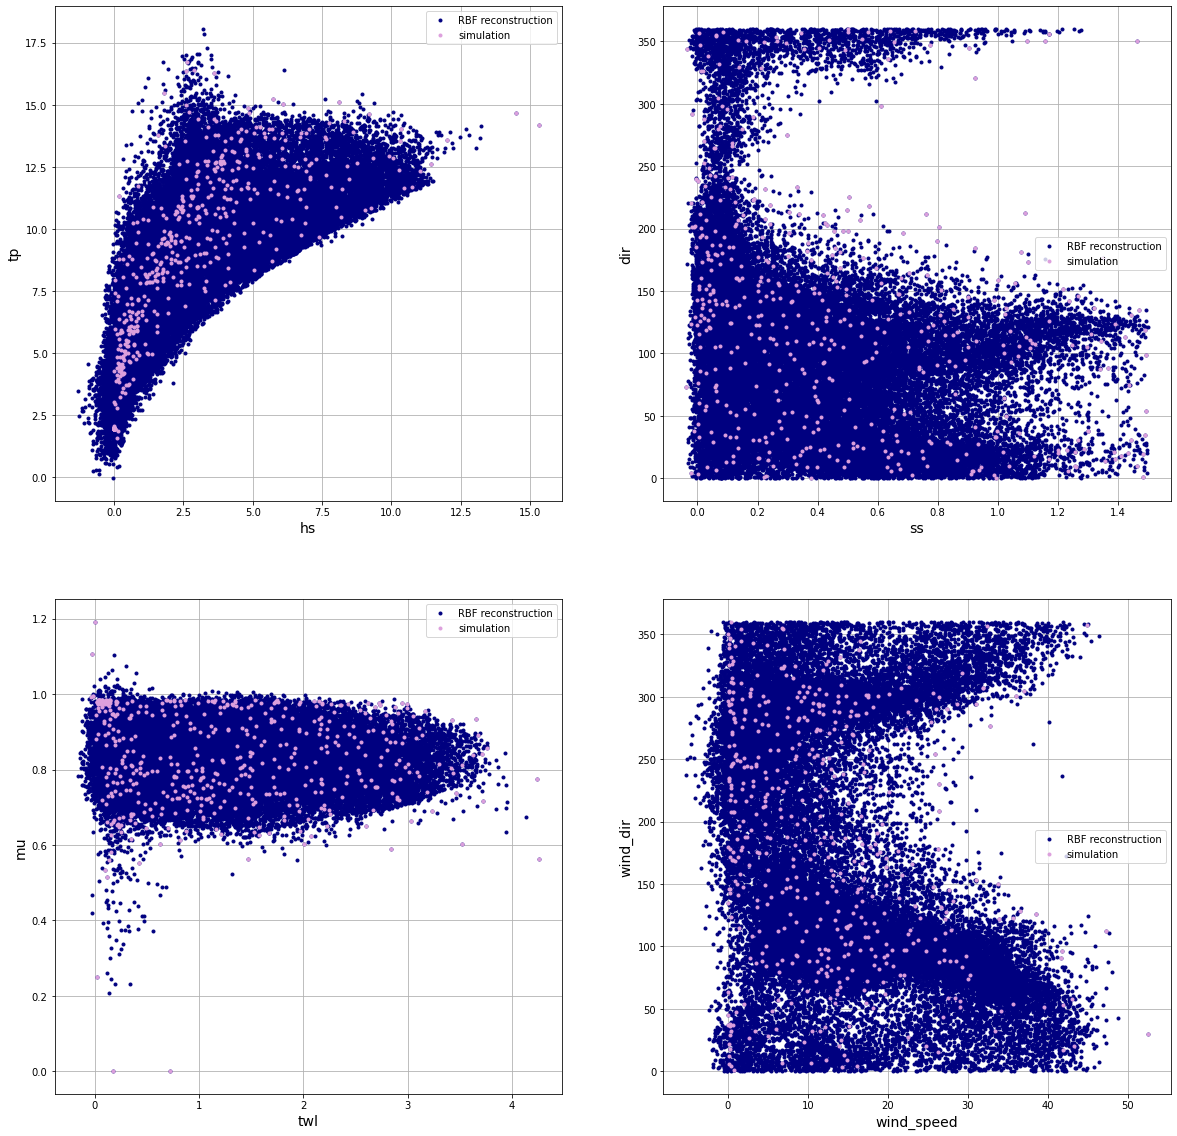

In [20]:
# PLOT

import matplotlib.pyplot as plt
from matplotlib import gridspec

var1 = 'hs'
var2 = 'tp'

fig=plt.figure(figsize=[20,20])
gs1=gridspec.GridSpec(2,2)
ax1=fig.add_subplot(gs1[0])
ax2=fig.add_subplot(gs1[1])
ax3=fig.add_subplot(gs1[2])
ax4=fig.add_subplot(gs1[3])

var1 = 'hs';  var2 = 'tp'
ax1.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax1.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax1.set_xlabel(var1,fontsize=14)
ax1.set_ylabel(var2,fontsize=14)
ax1.legend()
ax1.grid()

var1 = 'ss';  var2 = 'dir'
ax2.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax2.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax2.set_xlabel(var1,fontsize=14)
ax2.set_ylabel(var2,fontsize=14)
# ax2.set_ylim([0,360])
ax2.legend()
ax2.grid()

var1 = 'twl';  var2 = 'mu'
ax3.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax3.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax3.set_xlabel(var1,fontsize=14)
ax3.set_ylabel(var2,fontsize=14)
ax3.legend()
ax3.grid()

var1 = 'wind_speed';  var2 = 'wind_dir'
ax4.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax4.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax4.set_xlabel(var1,fontsize=14)
ax4.set_ylabel(var2,fontsize=14)
ax4.legend()
ax4.grid()

